# BERT Cased with Interweaving Fine-Tuned Approach on Disability and Nationality

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Imports

In [2]:
!pip install -q transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 90.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 103.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 26.7 MB/s eta 0:00:00


In [3]:
!pip install -q tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 38.3 MB/s eta 0:00:00


In [4]:
!pip3 install -q emoji==0.6.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [5]:
!pip install pyyaml h5py  # Required to save models in HDF5 format

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_addons as tfa
import transformers
from transformers import AutoTokenizer,TFBertModel

/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Functions and Constants

In [2]:
def to_arrays(df):
  X = df['comment_text'].to_numpy()
  y = df['toxicity_binary'].to_numpy()
  return X, y

In [3]:
MAX_SEQUENCE_LENGTH = 128

In [4]:
def tokenizing_pipeline(X, tokenizer):
  bert_tokenized = tokenizer(list(X),
                max_length=MAX_SEQUENCE_LENGTH,
                truncation=True,
                padding='max_length',
                return_tensors='tf')
  bert_inputs = [bert_tokenized.input_ids,
                 bert_tokenized.token_type_ids,
                 bert_tokenized.attention_mask]
  return bert_inputs

def load_data(group):
  df_train = pd.read_csv('drive/MyDrive/data/' + group + '-dataset-train-augmented.csv')
  df_val = pd.read_csv('drive/MyDrive/data/' + group + '-dataset-val-augmented.csv')
  df_test = pd.read_csv('drive/MyDrive/data/' + group + '-dataset-test-augmented.csv')

  return df_train, df_val, df_test

def load_data_as_arr(df_train, df_val, df_test):

  X_train, y_train = to_arrays(df_train)
  X_val, y_val = to_arrays(df_val)
  X_test, y_test = to_arrays(df_test)

  return X_train, y_train, X_test, y_test, X_val, y_val

In [5]:
def build_bertcased_cls_model(max_sequence_length=MAX_SEQUENCE_LENGTH,
                          hidden_size=100, 
                          dropout=0.3,
                          learning_rate=0.0001,
                          num_train_layers=0):

    # freeze all pre-trained BERT Cased layers
    if num_train_layers == 0:
      bertcased_model.trainable = False

    # partially freeze the first n pre-trained BERT Cased layers
    else:
        for layer_num in range(num_train_layers):
            bertcased_model.bert.encoder.layer[layer_num].trainable = False
    
    input_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}      

    # Use the same bertcased model instance
    bert_out = bertcased_model(bert_inputs)

    cls_token = bert_out[0][:, 0, :]

    
    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(cls_token)

    hidden = tf.keras.layers.Dropout(dropout)(hidden)  

    f1_score = tfa.metrics.F1Score(1, threshold = 0.5)

    classification = tf.keras.layers.Dense(1, activation='sigmoid', name='classification_layer')(hidden)
    
    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])
    
    classification_model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), 
                                 metrics=[tf.keras.metrics.BinaryAccuracy(),
                                        tf.keras.metrics.Precision(),
                                        tf.keras.metrics.Recall(),
                                        f1_score])

    return classification_model

## Load All Available Data for Disability and Nationality

In [6]:
# Disability
disability_train_df, disability_val_df, disability_test_df = load_data('disability')
X_disability_train, y_disability_train, X_disability_test, y_disability_test, X_disability_val, y_disability_val = load_data_as_arr(disability_train_df, disability_val_df, disability_test_df)

# Nationality
nationality_train_df, nationality_val_df, nationality_test_df = load_data('nationality')
X_nationality_train, y_nationality_train, X_nationality_test, y_nationality_test, X_nationality_val, y_nationality_val = load_data_as_arr(nationality_train_df, nationality_val_df, nationality_test_df)

In [7]:
X_disability_train[1]

' mental disability is extremely physical'

In [8]:
X_disability_train[9]

' There are many different types of disabilities. For example: mental, cognitive, visual, hearing, physical, and speech. Some people physically cannot speak English'

In [9]:
len(X_disability_train)

24904

In [10]:
X_nationality_train[0]

' most of the foods of the middle east are very healthy for you'

In [11]:
len(X_nationality_train)

28490

## Load BERT Cased Model from_pretrained()

In [12]:
bertcased_tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
bertcased_model = TFBertModel.from_pretrained('bert-base-cased')

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [13]:
bertcased_model.summary()

Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
Total params: 108,310,272
Trainable params: 108,310,272
Non-trainable params: 0
_________________________________________________________________


## Tokenize Data Splits

In [14]:
# Disability
bertcased_disability_train_inputs = tokenizing_pipeline(X_disability_train, bertcased_tokenizer)
bertcased_disability_test_inputs = tokenizing_pipeline(X_disability_test, bertcased_tokenizer)
bertcased_disability_val_inputs = tokenizing_pipeline(X_disability_val, bertcased_tokenizer)

# Nationality
bertcased_nationality_train_inputs = tokenizing_pipeline(X_nationality_train, bertcased_tokenizer)
bertcased_nationality_test_inputs = tokenizing_pipeline(X_nationality_test, bertcased_tokenizer)
bertcased_nationality_val_inputs = tokenizing_pipeline(X_nationality_val, bertcased_tokenizer)

# Calculate Class Weights for Each Group

Get class weights for disability train set:

In [15]:
neg, pos = np.bincount(y_disability_train)
total = neg + pos
print('Disability Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

disability_class_weight = {0: weight_for_0, 1: weight_for_1}

print('Disability Weight for class 0: {:.2f}'.format(weight_for_0))
print('Disability Weight for class 1: {:.2f}'.format(weight_for_1))

Disability Examples:
    Total: 24904
    Positive: 13009 (52.24% of total)

Disability Weight for class 0: 1.05
Disability Weight for class 1: 0.96


Get class weights for nationality train set:

In [16]:
neg, pos = np.bincount(y_nationality_train)
total = neg + pos
print('Nnationality Train Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

nationality_class_weight = {0: weight_for_0, 1: weight_for_1}

print('Nnationality Train Weight for class 0: {:.2f}'.format(weight_for_0))
print('Nnationality Train Weight for class 1: {:.2f}'.format(weight_for_1))

Nnationality Train Examples:
    Total: 28490
    Positive: 14575 (51.16% of total)

Nnationality Train Weight for class 0: 1.02
Nnationality Train Weight for class 1: 0.98


### Define Hyperparameters for both models

In [17]:
# hyperparameters
batch_size=24
num_train_layers=8
learning_rate=1e-6

# Build Disability Model

In [18]:
disability_model = build_bertcased_cls_model(num_train_layers=num_train_layers, learning_rate=learning_rate)
disability_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                              

# Build Nationality Model

In [19]:
nationality_model = build_bertcased_cls_model(num_train_layers=num_train_layers, learning_rate=learning_rate)
nationality_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                            

# Interweaving Fine-Tuning: Train Disability and Nationality Models on ther Respective Data

## Round 1: Train Disability Model for 1 epochs

In [20]:
disability_round1_history = disability_model.fit(bertcased_disability_train_inputs,
                                          y_disability_train,
                                          validation_data=(bertcased_disability_val_inputs, y_disability_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=disability_class_weight)

1038/1038 [==============================] - 98s 78ms/step - loss: 0.5830 - binary_accuracy: 0.6901 - precision: 0.7040 - recall: 0.7019 - f1_score: 0.7029 - val_loss: 0.4926 - val_binary_accuracy: 0.7707 - val_precision: 0.8019 - val_recall: 0.7408 - val_f1_score: 0.7702


## Round 2: Train Nationality Model for 1 epoch

In [21]:
nationality_round2_history = nationality_model.fit(bertcased_nationality_train_inputs,
                                          y_nationality_train,
                                          validation_data=(bertcased_nationality_val_inputs, y_nationality_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=nationality_class_weight)

1188/1188 [==============================] - 112s 81ms/step - loss: 0.5504 - binary_accuracy: 0.7135 - precision_1: 0.7250 - recall_1: 0.7089 - f1_score: 0.7168 - val_loss: 0.4606 - val_binary_accuracy: 0.7859 - val_precision_1: 0.8112 - val_recall_1: 0.7632 - val_f1_score: 0.7865


## Round 3: Train Disability Model for 1 epoch

In [22]:
disability_round3_history = disability_model.fit(bertcased_disability_train_inputs,
                                          y_disability_train,
                                          validation_data=(bertcased_disability_val_inputs, y_disability_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=disability_class_weight)

1038/1038 [==============================] - 78s 75ms/step - loss: 0.4826 - binary_accuracy: 0.7716 - precision: 0.7877 - recall: 0.7705 - f1_score: 0.7790 - val_loss: 0.4569 - val_binary_accuracy: 0.7866 - val_precision: 0.8110 - val_recall: 0.7673 - val_f1_score: 0.7885


## Round 4: Train Nationality Model on for 1 epoch

In [23]:
nationality_round4_history = nationality_model.fit(bertcased_nationality_train_inputs,
                                          y_nationality_train,
                                          validation_data=(bertcased_nationality_val_inputs, y_nationality_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=nationality_class_weight)

1188/1188 [==============================] - 92s 78ms/step - loss: 0.4585 - binary_accuracy: 0.7845 - precision_1: 0.7925 - recall_1: 0.7840 - f1_score: 0.7882 - val_loss: 0.4306 - val_binary_accuracy: 0.7992 - val_precision_1: 0.8213 - val_recall_1: 0.7812 - val_f1_score: 0.8008


## Round 5: Train Disability Model for 1 epoch

In [24]:
disability_round5_history = disability_model.fit(bertcased_disability_train_inputs,
                                          y_disability_train,
                                          validation_data=(bertcased_disability_val_inputs, y_disability_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=disability_class_weight)

1038/1038 [==============================] - 78s 75ms/step - loss: 0.4530 - binary_accuracy: 0.7887 - precision: 0.8078 - recall: 0.7814 - f1_score: 0.7944 - val_loss: 0.4441 - val_binary_accuracy: 0.7909 - val_precision: 0.8270 - val_recall: 0.7548 - val_f1_score: 0.7892


## Round 6: Train Nationality Model for 1 epoch

In [25]:
nationality_round6_history = nationality_model.fit(bertcased_nationality_train_inputs,
                                          y_nationality_train,
                                          validation_data=(bertcased_nationality_val_inputs, y_nationality_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=nationality_class_weight)

1188/1188 [==============================] - 92s 78ms/step - loss: 0.4342 - binary_accuracy: 0.7985 - precision_1: 0.8058 - recall_1: 0.7984 - f1_score: 0.8021 - val_loss: 0.4122 - val_binary_accuracy: 0.8120 - val_precision_1: 0.8243 - val_recall_1: 0.8085 - val_f1_score: 0.8163



## Round 7: Train Disability Model for 1 epoch

In [26]:
disability_round7_history = disability_model.fit(bertcased_disability_train_inputs,
                                          y_disability_train,
                                          validation_data=(bertcased_disability_val_inputs, y_disability_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=disability_class_weight)

1038/1038 [==============================] - 78s 75ms/step - loss: 0.4357 - binary_accuracy: 0.7956 - precision: 0.8146 - recall: 0.7881 - f1_score: 0.8011 - val_loss: 0.4313 - val_binary_accuracy: 0.7972 - val_precision: 0.8180 - val_recall: 0.7831 - val_f1_score: 0.8002


### Checkpoint #1: Save Model Weights

In [27]:
disability_model.save_weights('drive/MyDrive/model_checkpoints/Official_BERT_Cased_Disability_Nationality_Interwoven_disability-checkpt1-round_7.hdf5')

## Round 8: Train Nationality Model for 1 epoch

In [28]:
nationality_round8_history = nationality_model.fit(bertcased_nationality_train_inputs,
                                          y_nationality_train,
                                          validation_data=(bertcased_nationality_val_inputs, y_nationality_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=nationality_class_weight)

1188/1188 [==============================] - 93s 78ms/step - loss: 0.4172 - binary_accuracy: 0.8069 - precision_1: 0.8141 - recall_1: 0.8067 - f1_score: 0.8104 - val_loss: 0.4055 - val_binary_accuracy: 0.8152 - val_precision_1: 0.8429 - val_recall_1: 0.7893 - val_f1_score: 0.8152


## Round 9: Train Disability Model for 1 epoch

In [29]:
disability_round9_history = disability_model.fit(bertcased_disability_train_inputs,
                                          y_disability_train,
                                          validation_data=(bertcased_disability_val_inputs, y_disability_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=disability_class_weight)

1038/1038 [==============================] - 78s 75ms/step - loss: 0.4229 - binary_accuracy: 0.8027 - precision: 0.8237 - recall: 0.7918 - f1_score: 0.8074 - val_loss: 0.4239 - val_binary_accuracy: 0.8037 - val_precision: 0.8229 - val_recall: 0.7919 - val_f1_score: 0.8071


## Round 10: Train Nationality Model for 1 epoch

In [30]:
nationality_round10_history = nationality_model.fit(bertcased_nationality_train_inputs,
                                          y_nationality_train,
                                          validation_data=(bertcased_nationality_val_inputs, y_nationality_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=nationality_class_weight)

1188/1188 [==============================] - 92s 78ms/step - loss: 0.4035 - binary_accuracy: 0.8144 - precision_1: 0.8221 - recall_1: 0.8131 - f1_score: 0.8176 - val_loss: 0.3943 - val_binary_accuracy: 0.8206 - val_precision_1: 0.8374 - val_recall_1: 0.8101 - val_f1_score: 0.8235


## Round 11: Train Disability Model for 1 epoch

In [31]:
disability_round11_history = disability_model.fit(bertcased_disability_train_inputs,
                                          y_disability_train,
                                          validation_data=(bertcased_disability_val_inputs, y_disability_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=disability_class_weight)

1038/1038 [==============================] - 78s 75ms/step - loss: 0.4110 - binary_accuracy: 0.8113 - precision: 0.8306 - recall: 0.8024 - f1_score: 0.8162 - val_loss: 0.4197 - val_binary_accuracy: 0.8052 - val_precision: 0.8327 - val_recall: 0.7812 - val_f1_score: 0.8061


## Round 12: Train Nationality Model for 1 epoch

In [32]:
nationality_round12_history = nationality_model.fit(bertcased_nationality_train_inputs,
                                          y_nationality_train,
                                          validation_data=(bertcased_nationality_val_inputs, y_nationality_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=nationality_class_weight)

1188/1188 [==============================] - 92s 78ms/step - loss: 0.3947 - binary_accuracy: 0.8208 - precision_1: 0.8292 - recall_1: 0.8185 - f1_score: 0.8238 - val_loss: 0.3873 - val_binary_accuracy: 0.8251 - val_precision_1: 0.8383 - val_recall_1: 0.8195 - val_f1_score: 0.8288


## Round 13: Train Disability Model for 1 epoch

In [33]:
disability_round13_history = disability_model.fit(bertcased_disability_train_inputs,
                                          y_disability_train,
                                          validation_data=(bertcased_disability_val_inputs, y_disability_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=disability_class_weight)

1038/1038 [==============================] - 78s 75ms/step - loss: 0.4005 - binary_accuracy: 0.8197 - precision: 0.8409 - recall: 0.8078 - f1_score: 0.8240 - val_loss: 0.4181 - val_binary_accuracy: 0.8102 - val_precision: 0.8377 - val_recall: 0.7863 - val_f1_score: 0.8112


## Round 14: Train Nationality Model on for 1 epoch

In [34]:
nationality_round14_history = nationality_model.fit(bertcased_nationality_train_inputs,
                                          y_nationality_train,
                                          validation_data=(bertcased_nationality_val_inputs, y_nationality_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=nationality_class_weight)

1188/1188 [==============================] - 92s 78ms/step - loss: 0.3840 - binary_accuracy: 0.8244 - precision_1: 0.8312 - recall_1: 0.8241 - f1_score: 0.8276 - val_loss: 0.3858 - val_binary_accuracy: 0.8257 - val_precision_1: 0.8495 - val_recall_1: 0.8052 - val_f1_score: 0.8268


## Round 15: Train Disability Model for 1 epoch

In [35]:
disability_round15_history = disability_model.fit(bertcased_disability_train_inputs,
                                          y_disability_train,
                                          validation_data=(bertcased_disability_val_inputs, y_disability_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=disability_class_weight)

1038/1038 [==============================] - 78s 75ms/step - loss: 0.3935 - binary_accuracy: 0.8239 - precision: 0.8439 - recall: 0.8134 - f1_score: 0.8284 - val_loss: 0.4137 - val_binary_accuracy: 0.8107 - val_precision: 0.8284 - val_recall: 0.8007 - val_f1_score: 0.8144


## Round 16: Train Nationality Model on for 1 epoch

In [36]:
nationality_round16_history = nationality_model.fit(bertcased_nationality_train_inputs,
                                          y_nationality_train,
                                          validation_data=(bertcased_nationality_val_inputs, y_nationality_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=nationality_class_weight)

1188/1188 [==============================] - 92s 78ms/step - loss: 0.3776 - binary_accuracy: 0.8288 - precision_1: 0.8371 - recall_1: 0.8261 - f1_score: 0.8316 - val_loss: 0.3758 - val_binary_accuracy: 0.8303 - val_precision_1: 0.8355 - val_recall_1: 0.8362 - val_f1_score: 0.8358


### Checkpoint #2: Save Model Weights

In [37]:
nationality_model.save_weights('drive/MyDrive/model_checkpoints/Official_BERT_Cased_Disability_Nationality_Interwoven_nationality-checkpt2-rounds_16.hdf5')

## Round 17: Train Disability Model for 1 epoch

In [38]:
disability_round17_history = disability_model.fit(bertcased_disability_train_inputs,
                                          y_disability_train,
                                          validation_data=(bertcased_disability_val_inputs, y_disability_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=disability_class_weight)

1038/1038 [==============================] - 78s 75ms/step - loss: 0.3846 - binary_accuracy: 0.8273 - precision: 0.8466 - recall: 0.8177 - f1_score: 0.8319 - val_loss: 0.4136 - val_binary_accuracy: 0.8170 - val_precision: 0.8474 - val_recall: 0.7891 - val_f1_score: 0.8172


## Round 18: Train Nationality Model for 1 epoch

In [39]:
nationality_round18_history = nationality_model.fit(bertcased_nationality_train_inputs,
                                          y_nationality_train,
                                          validation_data=(bertcased_nationality_val_inputs, y_nationality_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=nationality_class_weight)

1188/1188 [==============================] - 93s 78ms/step - loss: 0.3700 - binary_accuracy: 0.8320 - precision_1: 0.8385 - recall_1: 0.8318 - f1_score: 0.8351 - val_loss: 0.3756 - val_binary_accuracy: 0.8303 - val_precision_1: 0.8549 - val_recall_1: 0.8089 - val_f1_score: 0.8312


# Plots for Disability Model

In [40]:
disability_train_f1_scores = [disability_round1_history.history['f1_score'][0][0], 
                     disability_round3_history.history['f1_score'][0][0],
                     disability_round5_history.history['f1_score'][0][0],
                     disability_round7_history.history['f1_score'][0][0],
                     disability_round9_history.history['f1_score'][0][0],
                     disability_round11_history.history['f1_score'][0][0],
                     disability_round13_history.history['f1_score'][0][0],
                     disability_round15_history.history['f1_score'][0][0],
                     disability_round17_history.history['f1_score'][0][0]]
disability_val_f1_scores = [disability_round1_history.history['val_f1_score'][0][0],
                     disability_round3_history.history['val_f1_score'][0][0],
                     disability_round5_history.history['val_f1_score'][0][0],
                     disability_round7_history.history['val_f1_score'][0][0],
                     disability_round9_history.history['val_f1_score'][0][0],
                     disability_round11_history.history['val_f1_score'][0][0],
                     disability_round13_history.history['val_f1_score'][0][0],
                     disability_round15_history.history['val_f1_score'][0][0],
                     disability_round17_history.history['val_f1_score'][0][0]]
disability_train_loss = [disability_round1_history.history['loss'][0],
                     disability_round3_history.history['loss'][0],
                     disability_round5_history.history['loss'][0],
                     disability_round7_history.history['loss'][0],
                     disability_round9_history.history['loss'][0],
                     disability_round11_history.history['loss'][0],
                     disability_round13_history.history['loss'][0],
                     disability_round15_history.history['loss'][0],
                     disability_round17_history.history['loss'][0]]
disability_val_loss = [disability_round1_history.history['val_loss'][0],
                     disability_round3_history.history['val_loss'][0],
                     disability_round5_history.history['val_loss'][0],
                     disability_round7_history.history['val_loss'][0],
                     disability_round9_history.history['val_loss'][0],
                     disability_round11_history.history['val_loss'][0],
                     disability_round13_history.history['val_loss'][0],
                     disability_round15_history.history['val_loss'][0],
                     disability_round17_history.history['val_loss'][0]]
disability_train_binary_accuracy = [disability_round1_history.history['binary_accuracy'][0],
                     disability_round3_history.history['binary_accuracy'][0],
                     disability_round5_history.history['binary_accuracy'][0],
                     disability_round7_history.history['binary_accuracy'][0],
                     disability_round9_history.history['binary_accuracy'][0],
                     disability_round11_history.history['binary_accuracy'][0],
                     disability_round13_history.history['binary_accuracy'][0],
                     disability_round15_history.history['binary_accuracy'][0],
                     disability_round17_history.history['binary_accuracy'][0]]
disability_val_binary_accuracy = [disability_round1_history.history['val_binary_accuracy'][0],
                     disability_round3_history.history['val_binary_accuracy'][0],
                     disability_round5_history.history['val_binary_accuracy'][0],
                     disability_round7_history.history['val_binary_accuracy'][0],
                     disability_round9_history.history['val_binary_accuracy'][0],
                     disability_round11_history.history['val_binary_accuracy'][0],
                     disability_round13_history.history['val_binary_accuracy'][0],
                     disability_round15_history.history['val_binary_accuracy'][0],
                     disability_round17_history.history['val_binary_accuracy'][0]]

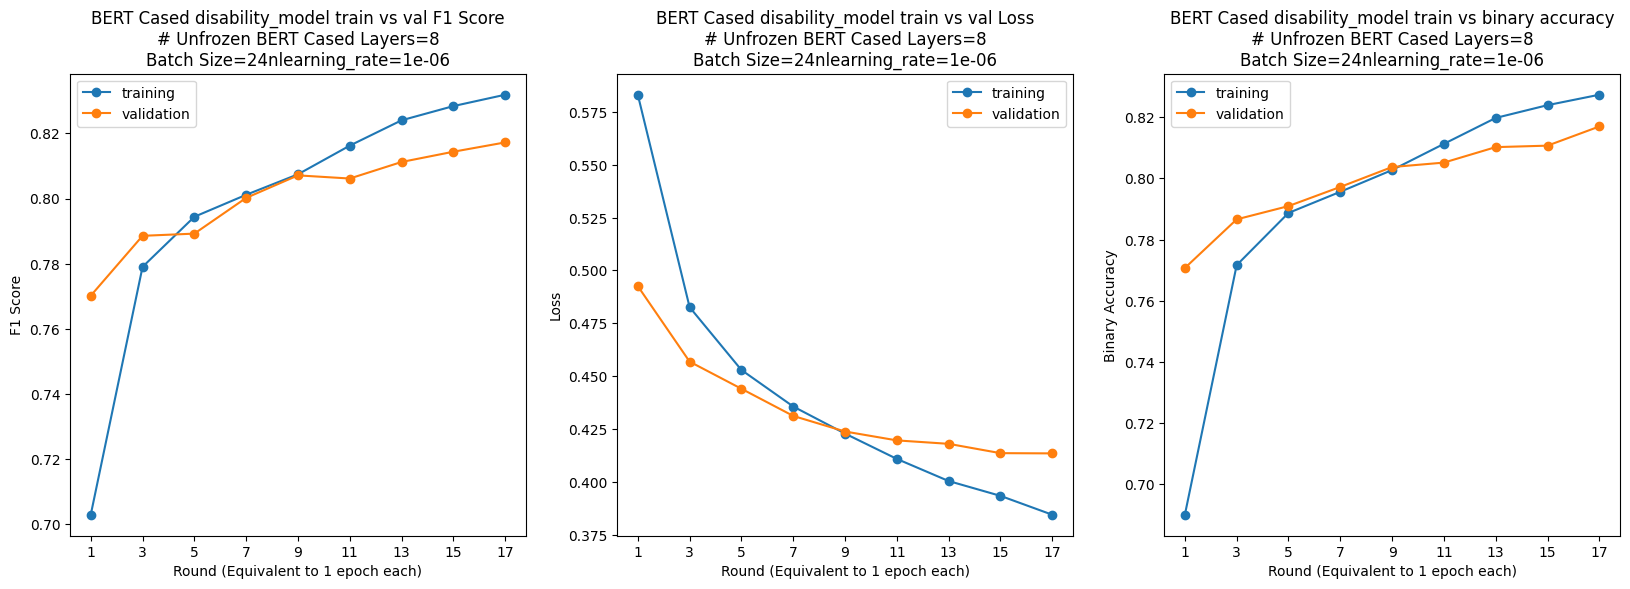

In [41]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(1, 3, figsize=(20,6))

# F1 Score
axis[0].plot(disability_train_f1_scores, label="training", marker='o')
axis[0].plot(disability_val_f1_scores, label="validation", marker='o')
axis[0].legend()
axis[0].set_ylabel('F1 Score')
axis[0].set_xlabel('Round (Equivalent to 1 epoch each)')
axis[0].set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], ['1', '3', '5', '7', '9', '11', '13', '15', '17'])
axis[0].set_title('BERT Cased disability_model train vs val F1 Score\n'+'# Unfrozen BERT Cased Layers='+str(num_train_layers)+'\nBatch Size='+str(batch_size)+'nlearning_rate='+str(learning_rate))

# Loss
axis[1].plot(disability_train_loss, label="training", marker='o')
axis[1].plot(disability_val_loss, label="validation", marker='o')
axis[1].legend()
axis[1].set_ylabel('Loss')
axis[1].set_xlabel('Round (Equivalent to 1 epoch each)')
axis[1].set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], ['1', '3', '5', '7', '9', '11', '13', '15', '17'])
axis[1].set_title('BERT Cased disability_model train vs val Loss\n'+'# Unfrozen BERT Cased Layers='+str(num_train_layers)+'\nBatch Size='+str(batch_size)+'nlearning_rate='+str(learning_rate))

# Binary Accuracy
axis[2].plot(disability_train_binary_accuracy, label="training", marker='o')
axis[2].plot(disability_val_binary_accuracy, label="validation", marker='o')
axis[2].legend()
axis[2].set_ylabel('Binary Accuracy')
axis[2].set_xlabel('Round (Equivalent to 1 epoch each)')
axis[2].set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], ['1', '3', '5', '7', '9', '11', '13', '15', '17'])
axis[2].set_title('BERT Cased disability_model train vs binary accuracy\n'+'# Unfrozen BERT Cased Layers='+str(num_train_layers)+'\nBatch Size='+str(batch_size)+'nlearning_rate='+str(learning_rate))
  
# Combine all the operations and display
plt.show()

# Plots for Nationality Model

In [42]:
nationality_train_f1_scores = [nationality_round2_history.history['f1_score'][0][0],
                     nationality_round4_history.history['f1_score'][0][0],
                     nationality_round6_history.history['f1_score'][0][0],
                     nationality_round8_history.history['f1_score'][0][0],
                     nationality_round10_history.history['f1_score'][0][0],
                     nationality_round12_history.history['f1_score'][0][0],
                     nationality_round14_history.history['f1_score'][0][0],
                     nationality_round16_history.history['f1_score'][0][0],
                     nationality_round18_history.history['f1_score'][0][0]]
nationality_val_f1_scores = [nationality_round2_history.history['val_f1_score'][0][0],
                     nationality_round4_history.history['val_f1_score'][0][0],
                     nationality_round6_history.history['val_f1_score'][0][0],
                     nationality_round8_history.history['val_f1_score'][0][0],
                     nationality_round10_history.history['val_f1_score'][0][0],
                     nationality_round12_history.history['val_f1_score'][0][0],
                     nationality_round14_history.history['val_f1_score'][0][0],
                     nationality_round16_history.history['val_f1_score'][0][0],
                     nationality_round18_history.history['val_f1_score'][0][0]]
nationality_train_loss = [nationality_round2_history.history['loss'][0],
                     nationality_round4_history.history['loss'][0],
                     nationality_round6_history.history['loss'][0],
                     nationality_round8_history.history['loss'][0],
                     nationality_round10_history.history['loss'][0],
                     nationality_round12_history.history['loss'][0],
                     nationality_round14_history.history['loss'][0],
                     nationality_round16_history.history['loss'][0],
                     nationality_round18_history.history['loss'][0]]
nationality_val_loss = [nationality_round2_history.history['val_loss'][0],
                     nationality_round4_history.history['val_loss'][0],
                     nationality_round6_history.history['val_loss'][0],
                     nationality_round8_history.history['val_loss'][0],
                     nationality_round10_history.history['val_loss'][0],
                     nationality_round12_history.history['val_loss'][0],
                     nationality_round14_history.history['val_loss'][0],
                     nationality_round16_history.history['val_loss'][0],
                     nationality_round18_history.history['val_loss'][0]]
nationality_train_binary_accuracy = [nationality_round2_history.history['binary_accuracy'][0],
                     nationality_round4_history.history['binary_accuracy'][0],
                     nationality_round6_history.history['binary_accuracy'][0],
                     nationality_round8_history.history['binary_accuracy'][0],
                     nationality_round10_history.history['binary_accuracy'][0],
                     nationality_round12_history.history['binary_accuracy'][0],
                     nationality_round14_history.history['binary_accuracy'][0],
                     nationality_round16_history.history['binary_accuracy'][0],
                     nationality_round18_history.history['binary_accuracy'][0]]
nationality_val_binary_accuracy = [nationality_round2_history.history['val_binary_accuracy'][0],
                     nationality_round4_history.history['val_binary_accuracy'][0],
                     nationality_round6_history.history['val_binary_accuracy'][0],
                     nationality_round8_history.history['val_binary_accuracy'][0],
                     nationality_round10_history.history['val_binary_accuracy'][0],
                     nationality_round12_history.history['val_binary_accuracy'][0],
                     nationality_round14_history.history['val_binary_accuracy'][0],
                     nationality_round16_history.history['val_binary_accuracy'][0],
                     nationality_round18_history.history['val_binary_accuracy'][0]]


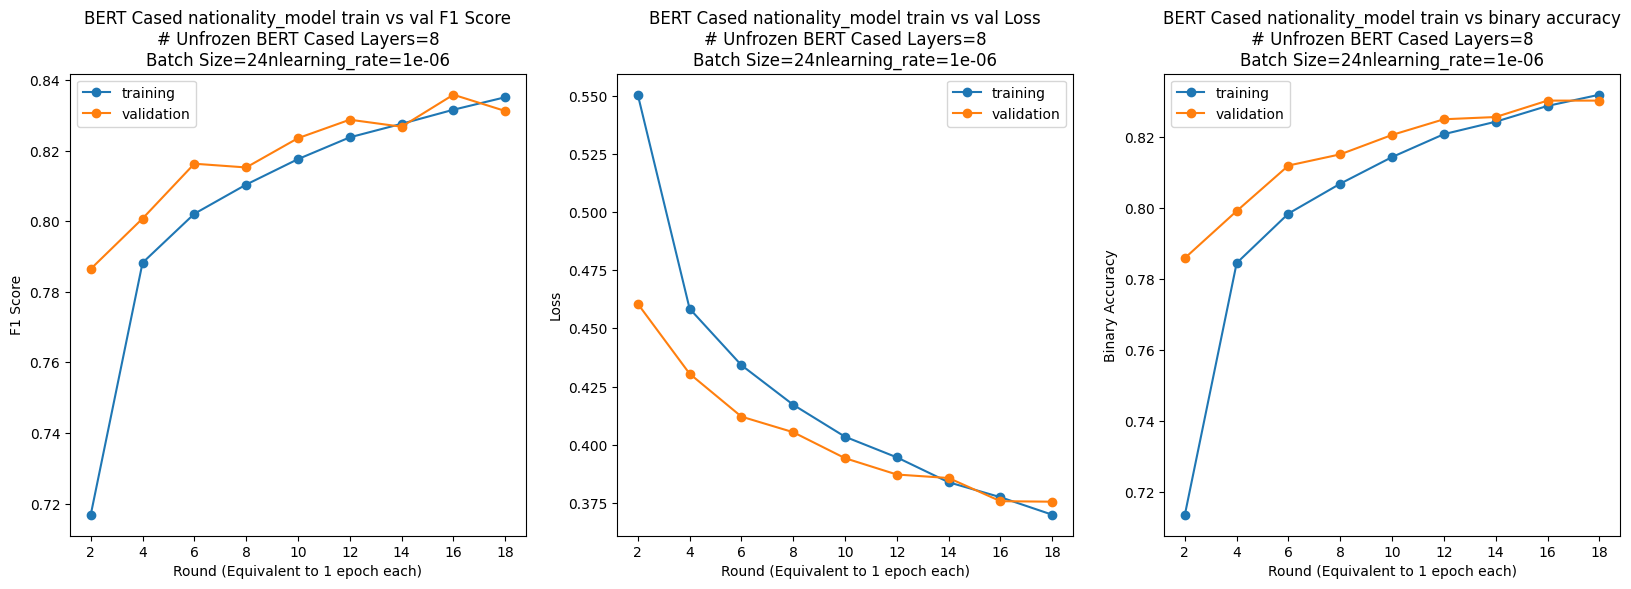

In [43]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(1, 3, figsize=(20,6))

# F1 Score
axis[0].plot(nationality_train_f1_scores, label="training", marker='o')
axis[0].plot(nationality_val_f1_scores, label="validation", marker='o')
axis[0].legend()
axis[0].set_ylabel('F1 Score')
axis[0].set_xlabel('Round (Equivalent to 1 epoch each)')
axis[0].set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], ['2', '4', '6', '8', '10', '12', '14', '16', '18'])
axis[0].set_title('BERT Cased nationality_model train vs val F1 Score\n'+'# Unfrozen BERT Cased Layers='+str(num_train_layers)+'\nBatch Size='+str(batch_size)+'nlearning_rate='+str(learning_rate))

# Loss
axis[1].plot(nationality_train_loss, label="training", marker='o')
axis[1].plot(nationality_val_loss, label="validation", marker='o')
axis[1].legend()
axis[1].set_ylabel('Loss')
axis[1].set_xlabel('Round (Equivalent to 1 epoch each)')
axis[1].set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], ['2', '4', '6', '8', '10', '12', '14', '16', '18'])
axis[1].set_title('BERT Cased nationality_model train vs val Loss\n'+'# Unfrozen BERT Cased Layers='+str(num_train_layers)+'\nBatch Size='+str(batch_size)+'nlearning_rate='+str(learning_rate))

# Binary Accuracy
axis[2].plot(nationality_train_binary_accuracy, label="training", marker='o')
axis[2].plot(nationality_val_binary_accuracy, label="validation", marker='o')
axis[2].legend()
axis[2].set_ylabel('Binary Accuracy')
axis[2].set_xlabel('Round (Equivalent to 1 epoch each)')
axis[2].set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], ['2', '4', '6', '8', '10', '12', '14', '16', '18'])
axis[2].set_title('BERT Cased nationality_model train vs binary accuracy\n'+'# Unfrozen BERT Cased Layers='+str(num_train_layers)+'\nBatch Size='+str(batch_size)+'nlearning_rate='+str(learning_rate))
  
# Combine all the operations and display
plt.show()

# Save Final Model Weights if Needed

In [ ]:
disability_model.save_weights('drive/MyDrive/model_checkpoints/Official_BERT_Cased_Disability_Nationality_Interwoven_disability.hdf5')
nationality_model.save_weights('drive/MyDrive/model_checkpoints/Official_BERT_Cased_Disability_Nationality_Interwoven_nationality.hdf5')

# Keep Previous Results Below/Determine Where to Stop Training

DISABILITY MODEL RESULTS

In [51]:
print('disability_train_f1_scores:', disability_train_f1_scores)
print('disability_val_f1_scores:', disability_val_f1_scores)
print('\ndisability_train_loss:', disability_train_loss)
print('disability_val_loss:', disability_val_loss)
print('\ndisability_train_binary_accuracy:', disability_train_binary_accuracy)
print('disability_val_binary_accuracy:', disability_val_binary_accuracy)

disability_train_f1_scores: [0.69243413, 0.7726795, 0.78995204, 0.80214447, 0.8112964, 0.8158059, 0.81901926, 0.8282741, 0.8308115]
disability_val_f1_scores: [0.76333654, 0.78214467, 0.7893474, 0.80018896, 0.80097675, 0.8052452, 0.81636447, 0.8129889, 0.8171482]

disability_train_loss: [0.595196008682251, 0.48672646284103394, 0.4583466053009033, 0.43899527192115784, 0.4240172505378723, 0.4140654504299164, 0.40607142448425293, 0.39570799469947815, 0.38969314098358154]
disability_val_loss: [0.4933196008205414, 0.4618965983390808, 0.44313958287239075, 0.430515319108963, 0.4278518557548523, 0.42110586166381836, 0.41287240386009216, 0.4130897521972656, 0.4081534743309021]

disability_train_binary_accuracy: [0.6769595146179199, 0.7654593586921692, 0.7837696671485901, 0.7969803810119629, 0.8060150742530823, 0.8109540343284607, 0.814608097076416, 0.8237230777740479, 0.8266944885253906]
disability_val_binary_accuracy: [0.7649325728416443, 0.7837187051773071, 0.7885356545448303, 0.79624277353286

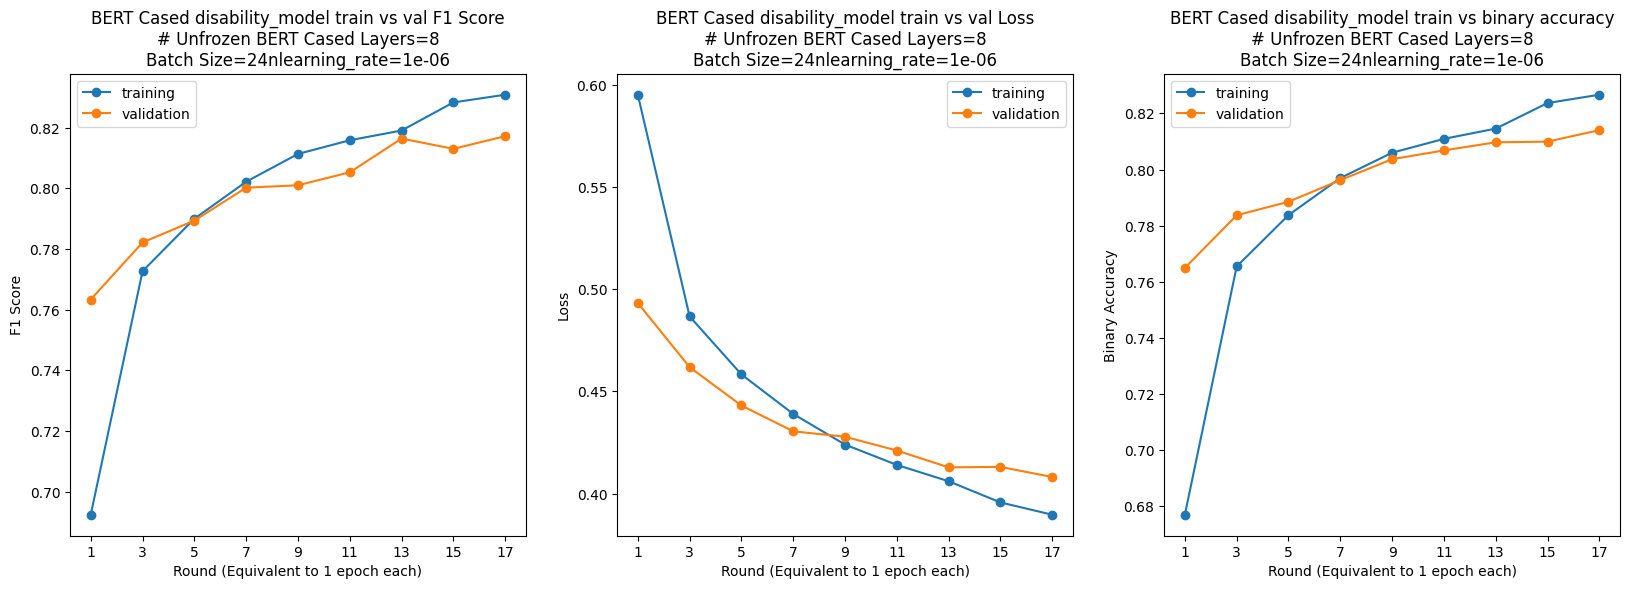

In [ ]:
# DISABILITY MODEL PLOTS - DON'T RUN THIS CELL
# From the curves below, we'll keep the disability_model weights at round 7

NATIONALITY MODEL RESULTS

In [52]:
print('nationality_train_f1_scores:', nationality_train_f1_scores)
print('nationality_val_f1_scores:', nationality_val_f1_scores)
print('\nnationality_train_loss:', nationality_train_loss)
print('nationality_val_loss:', nationality_val_loss)
print('\nnationality_train_binary_accuracy:', nationality_train_binary_accuracy)
print('nationality_val_binary_accuracy:', nationality_val_binary_accuracy)

nationality_train_f1_scores: [0.6796291, 0.78331167, 0.80063105, 0.8100309, 0.818088, 0.82349706, 0.83053416, 0.83243614, 0.8389333]
nationality_val_f1_scores: [0.7825367, 0.8013232, 0.8082192, 0.8207835, 0.82338667, 0.82108355, 0.83313084, 0.8331632, 0.83319473]

nationality_train_loss: [0.5787262320518494, 0.4638846218585968, 0.4391140937805176, 0.4196271300315857, 0.4078235924243927, 0.395001083612442, 0.3844061493873596, 0.37800589203834534, 0.37091967463493347]
nationality_val_loss: [0.4655652344226837, 0.4358082413673401, 0.41991758346557617, 0.40363460779190063, 0.39427196979522705, 0.39259663224220276, 0.38272953033447266, 0.3778870403766632, 0.3761674761772156]

nationality_train_binary_accuracy: [0.6859599947929382, 0.7779572010040283, 0.79596346616745, 0.8058968186378479, 0.8143208026885986, 0.819761335849762, 0.8271674513816833, 0.8284661173820496, 0.8352755308151245]
nationality_val_binary_accuracy: [0.7787368297576904, 0.7976841926574707, 0.8054736852645874, 0.81410527229

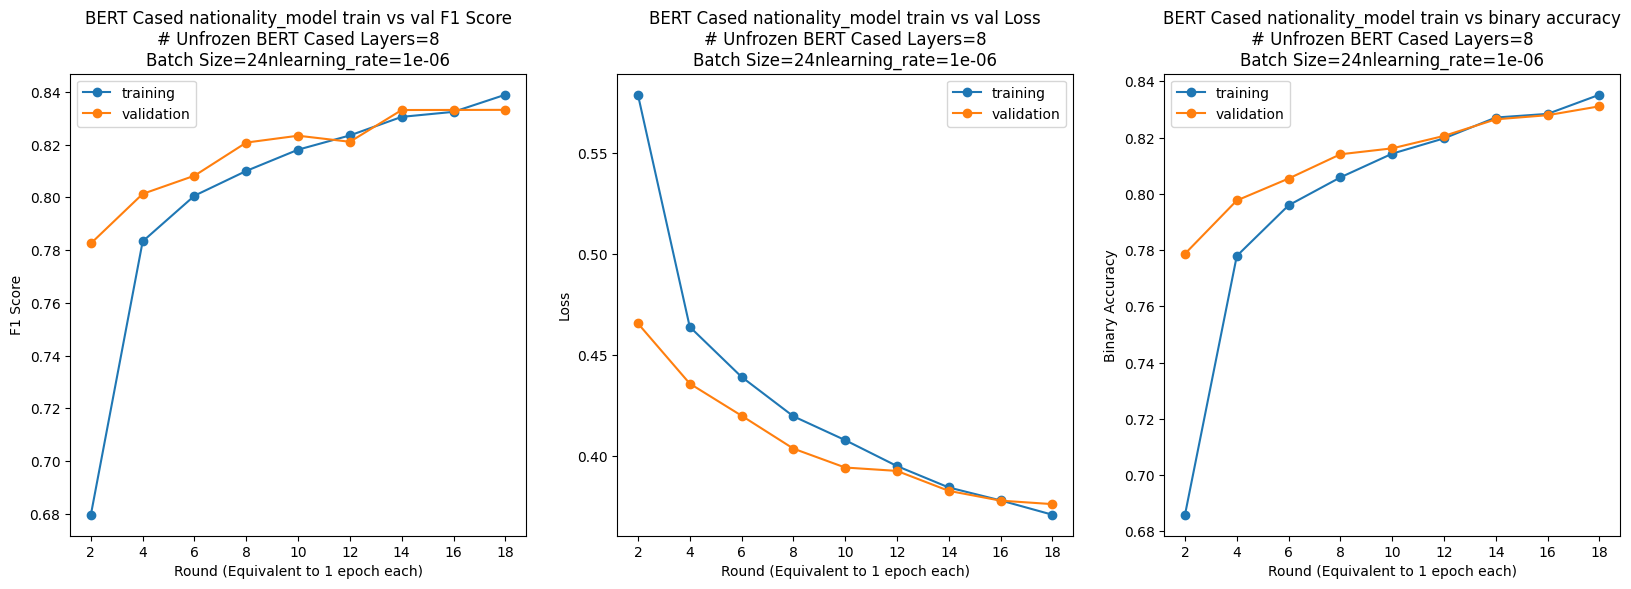

In [ ]:
# NATIONALITY MODEL PLOTS - DON'T RUN THIS CELL
# From the curves below, we'll keep the nationality_model weights at round 16